<a href="https://colab.research.google.com/github/youngvn/How-to-learn-Machine-Learning/blob/master/House_Price_Advanced_Regression_Techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
auth.authenticate_user()
drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])
filename = "/root/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [2]:
!pip install kaggle

In [3]:
PATH = "data/house_prices/"
!kaggle competitions files -c house-prices-advanced-regression-techniques
!kaggle competitions download  -c house-prices-advanced-regression-techniques -p '{PATH}'

name                    size  creationDate         
---------------------  -----  -------------------  
sample_submission.csv   31KB  2018-11-28 22:31:52  
test.csv               441KB  2018-11-28 22:31:52  
train.csv              450KB  2018-11-28 22:31:49  
data_description.txt    13KB  2018-11-28 22:31:50  
  0% 0.00/31.2k [00:00<?, ?B/s]
100% 31.2k/31.2k [00:00<00:00, 12.1MB/s]
  0% 0.00/441k [00:00<?, ?B/s]
100% 441k/441k [00:00<00:00, 60.5MB/s]
  0% 0.00/450k [00:00<?, ?B/s]
100% 450k/450k [00:00<00:00, 56.2MB/s]
  0% 0.00/13.1k [00:00<?, ?B/s]
100% 13.1k/13.1k [00:00<00:00, 13.1MB/s]


In [5]:
!ls {PATH}

data_description.txt  sample_submission.csv  test.csv  train.csv


In [0]:
import pandas as pd
import numpy as np

In [0]:
train_csv = f'{PATH}train.csv'
test_csv = f'{PATH}test.csv'
train = pd.read_csv(train_csv)
test = pd.read_csv(test_csv)

In [10]:
print ("Train data shape:", train.shape)
print ("Test data shape:", test.shape)

Train data shape: (1460, 81)
Test data shape: (1459, 80)


In [11]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [0]:
import matplotlib.pyplot as plt
plt.style.use(style='ggplot')
plt.rcParams['figure.figsize'] = (10, 6)

In [13]:
train.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Skew is: 1.8828757597682129


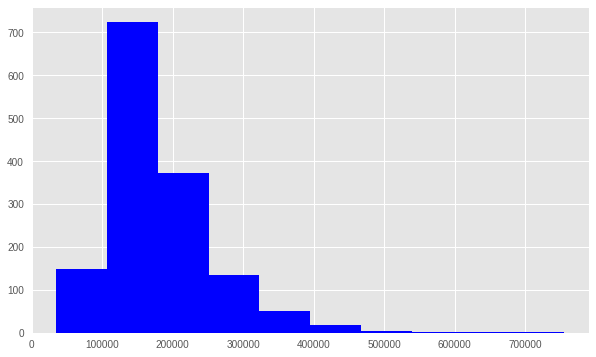

In [14]:
print ("Skew is:", train.SalePrice.skew())
plt.hist(train.SalePrice, color='blue')
plt.show()

Notice that the distribution has a longer tail on the right. The distribution is positively skewed.

Now we use np.log() to transform train.SalePric and calculate the skewness a second time, as well as re-plot the data. 

A value closer to 0 means that we have improved the skewness of the data. 

Skew is: 0.12133506220520406


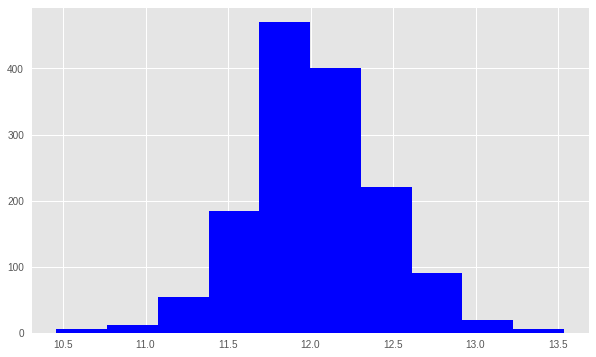

In [15]:
target = np.log(train.SalePrice)
print ("Skew is:", target.skew())
plt.hist(target, color='blue')
plt.show()

let's consider our features. First, we'll check out the numerical features and make some plots. The .select_dtypes() method will return a subset of columns matching the specified data types.

In [16]:
numeric_features = train.select_dtypes(include=[np.number])
numeric_features.dtypes

Id                 int64
MSSubClass         int64
LotFrontage      float64
LotArea            int64
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
MasVnrArea       float64
BsmtFinSF1         int64
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
1stFlrSF           int64
2ndFlrSF           int64
LowQualFinSF       int64
GrLivArea          int64
BsmtFullBath       int64
BsmtHalfBath       int64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
TotRmsAbvGrd       int64
Fireplaces         int64
GarageYrBlt      float64
GarageCars         int64
GarageArea         int64
WoodDeckSF         int64
OpenPorchSF        int64
EnclosedPorch      int64
3SsnPorch          int64
ScreenPorch        int64
PoolArea           int64
MiscVal            int64
MoSold             int64
YrSold             int64
SalePrice          int64
dtype: object

The DataFrame.corr() method displays the correlation (or relationship) between the columns. We'll examine the correlations between the features and the target.

In [18]:
corr = numeric_features.corr()

print (corr['SalePrice'].sort_values(ascending=False)[:5], '\n')
print (corr['SalePrice'].sort_values(ascending=False)[-5:])

SalePrice      1.000000
OverallQual    0.790982
GrLivArea      0.708624
GarageCars     0.640409
GarageArea     0.623431
Name: SalePrice, dtype: float64 

YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64


Let's dig deeper on OverallQual. We can use the .unique() method to get the unique values.

In [20]:
train.OverallQual.unique()

array([ 7,  6,  8,  5,  9,  4, 10,  3,  1,  2])

The OverallQual data are integer values in the interval 1 to 10 inclusive.
We can create a pivot table to further investigate the relationship between OverallQual and SalePrice. The Pandas docs demonstrate how to accomplish this task. We set index='OverallQual' and values='SalePrice'. 

In [0]:
quality_pivot = train.pivot_table(index='OverallQual',
                                  values='SalePrice', aggfunc=np.median)

In [22]:
quality_pivot

,SalePrice
OverallQual,
1,50150
2,60000
3,86250
4,108000
5,133000
6,160000
7,200141
8,269750
9,345000


To help us visualize this pivot table more easily, we can create a bar plot using the Series.plot() method.

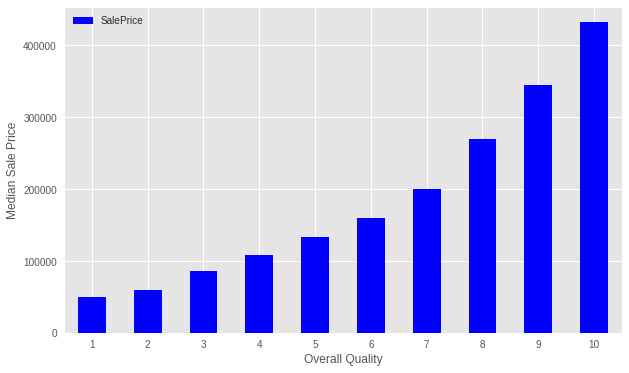

In [23]:
quality_pivot.plot(kind='bar', color='blue')
plt.xlabel('Overall Quality')
plt.ylabel('Median Sale Price')
plt.xticks(rotation=0)
plt.show()

Notice that the median sales price strictly increases as Overall Quality increases.

let's use plt.scatter() to generate some scatter plots and visualize the relationship between the Ground Living Area GrLivArea and SalePrice.

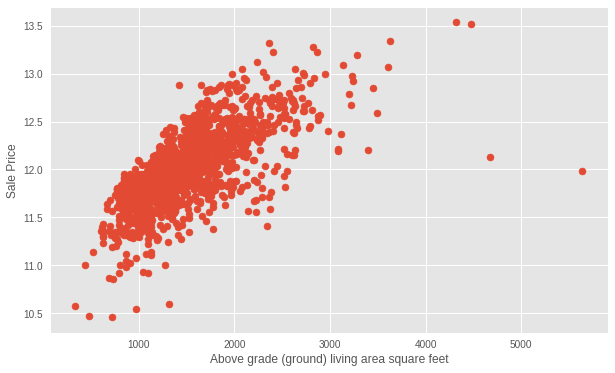

In [25]:
plt.scatter(x=train['GrLivArea'], y=target)
plt.ylabel('Sale Price')
plt.xlabel('Above grade (ground) living area square feet')
plt.show()

At first glance, we see that increases in living area correspond to increases in price.

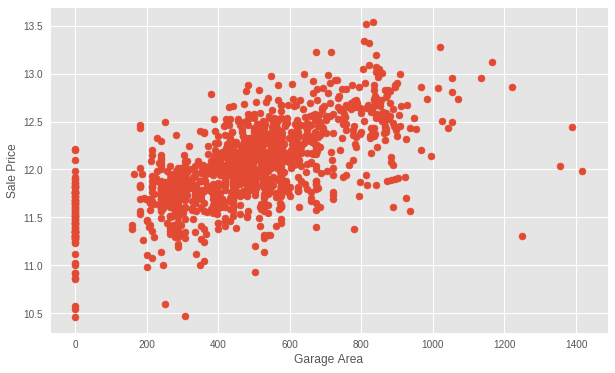

In [27]:
plt.scatter(x=train['GarageArea'], y=target)
plt.ylabel('Sale Price')
plt.xlabel('Garage Area')
plt.show()

Notice that there are many homes with 0 for Garage Area, indicating that they don't have a garage. We'll transform other features later to reflect this assumption. 

There are a few outliers as well. Outliers can affect a regression model by pulling our estimated regression line further away from the true population regression line. 

In [0]:
train = train[train['GarageArea'] < 1200]

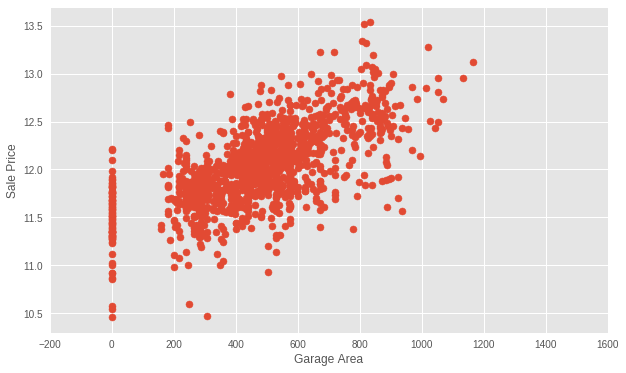

In [29]:
plt.scatter(x=train['GarageArea'], y=np.log(train.SalePrice))
plt.xlim(-200,1600) # This forces the same scale as before
plt.ylabel('Sale Price')
plt.xlabel('Garage Area')
plt.show()

Handling Null Values

In [30]:
nulls = pd.DataFrame(train.isnull().sum().sort_values(ascending=False)[:25])
nulls.columns = ['Null Count']
nulls.index.name = 'Feature'
nulls

,Null Count
Feature,
PoolQC,1449
MiscFeature,1402
Alley,1364
Fence,1174
FireplaceQu,689
LotFrontage,258
GarageCond,81
GarageType,81
GarageYrBlt,81


 In the case of PoolQC, the column refers to Pool Quality. Pool quality is NaN when PoolArea is 0, or there is no pool.
We can find a similar relationship between many of the Garage-related columns.

In [31]:
print ("Unique values are:", train.MiscFeature.unique())

Unique values are: [nan 'Shed' 'Gar2' 'Othr' 'TenC']


Elev Elevator
   Gar2 2nd Garage (if not described in garage section)
   Othr Other
   Shed Shed (over 100 SF)
   TenC Tennis Court
   NA   None

These values describe whether or not the house has a shed over 100 sqft, a second garage, and so on. We might want to use this information later. It's important to gather domain knowledge in order to make the best decisions when dealing with missing data.

##Wrangling the non-numeric Features

In [33]:
categoricals = train.select_dtypes(exclude=[np.number])
categoricals.describe()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1455,1455,91,1455,1455,1455,1455,1455,1455,1455,...,1374,1374,1374,1374,1455,6,281,53,1455,1455
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1147,1450,50,921,1309,1454,1048,1378,225,1257,...,867,605,1306,1321,1335,2,157,48,1266,1196


top is the most commonly occurring value, with the frequency of the top value shown by freq.

For many of these features, we might want to use one-hot encoding to make use of the information for modeling.
One-hot encoding is a technique which will transform categorical data into numbers so the model can understand whether or not a particular observation falls into one category or another.

When transforming features, it's important to remember that any transformations that you've applied to the training data before fitting the model must be applied to the test data.

To demonstrate how this works, consider the Street data, which indicates whether there is Gravel or Paved road access to the property.

In [34]:
print ("Original: \n") 
print (train.Street.value_counts(), "\n")

Original: 

Pave    1450
Grvl       5
Name: Street, dtype: int64 



In the Street column, the unique values are Pave and Grvl, which describe the type of road access to the property. In the training set, only 5 homes have gravel access. Our model needs numerical data, so we will use one-hot encoding to transform the data into a Boolean column.



In [0]:
train['enc_street'] = pd.get_dummies(train.Street, drop_first=True)
test['enc_street'] = pd.get_dummies(train.Street, drop_first=True)

In [36]:
print ('Encoded: \n') 
print (train.enc_street.value_counts())

Encoded: 

1    1450
0       5
Name: enc_street, dtype: int64


We'll look at SaleCondition by constructing and plotting a pivot table, as we did above for OverallQual.

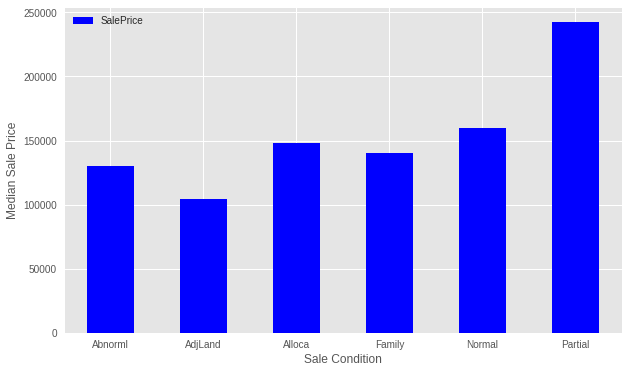

In [37]:
condition_pivot = train.pivot_table(index='SaleCondition',
                                    values='SalePrice', aggfunc=np.median)
condition_pivot.plot(kind='bar', color='blue')
plt.xlabel('Sale Condition')
plt.ylabel('Median Sale Price')
plt.xticks(rotation=0)
plt.show()

Notice that Partial has a significantly higher Median Sale Price than the others. We will encode this as a new feature. We select all of the houses where SaleCondition is equal to Patrial and assign the value 1, otherwise assign 0.

In [0]:
def encode(x): return 1 if x == 'Partial' else 0
train['enc_condition'] = train.SaleCondition.apply(encode)
test['enc_condition'] = test.SaleCondition.apply(encode)

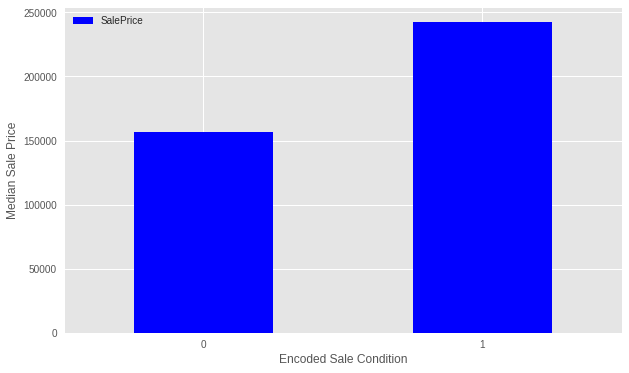

In [39]:
condition_pivot = train.pivot_table(index='enc_condition', values='SalePrice', aggfunc=np.median)
condition_pivot.plot(kind='bar', color='blue')
plt.xlabel('Encoded Sale Condition')
plt.ylabel('Median Sale Price')
plt.xticks(rotation=0)
plt.show()

This is a quick and simple method of dealing with missing values, and might not lead to the best performance of the model on new data. Handling missing values is an important part of the modeling process, where creativity and insight can make a big difference. This is another area where you can extend on this tutorial.

In [0]:
data = train.select_dtypes(include=[np.number]).interpolate().dropna()

In [41]:
sum(data.isnull().sum() != 0)

0

### Step 3 : Build a linear model
We use np.log() as explained above to transform the y variable for the model. 



In [0]:
y = np.log(train.SalePrice)
X = data.drop(['SalePrice', 'Id'], axis=1)

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
                                    X, y, random_state=42, test_size=.33)

In [0]:
from sklearn import linear_model
lr = linear_model.LinearRegression()

In [0]:
model = lr.fit(X_train, y_train)

Each competition might evaluate the submissions differently. In this competition, Kaggle will evaluate our submission using root-mean-squared-error (RMSE). We'll also look at The r-squared value.

In [46]:
print ("R^2 is: \n", model.score(X_test, y_test))

R^2 is: 
 0.8882477709262494


This means that our features explain approximately 89% of the variance in our target variable. Follow the link above to learn more.



In [0]:
predictions = model.predict(X_test)

In [48]:
from sklearn.metrics import mean_squared_error
print ('RMSE is: \n', mean_squared_error(y_test, predictions))

RMSE is: 
 0.017841794519568518


The RMSE measures the distance between our predicted values and actual values.

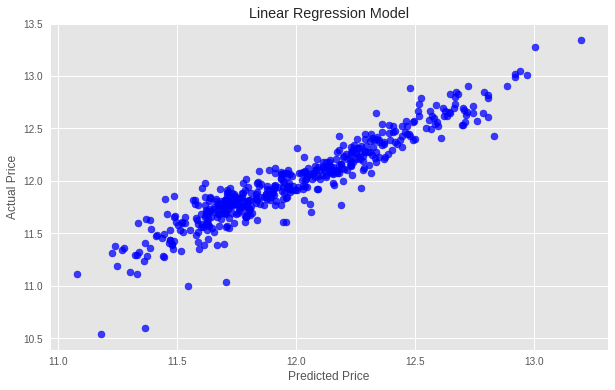

In [49]:
actual_values = y_test
plt.scatter(predictions, actual_values, alpha=.75,
            color='b') #alpha helps to show overlapping data
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Linear Regression Model')
plt.show()

We'll next try using Ridge Regularization to decrease the influence of less important features. Ridge Regularization is a process which shrinks the regression coefficients of less important features.

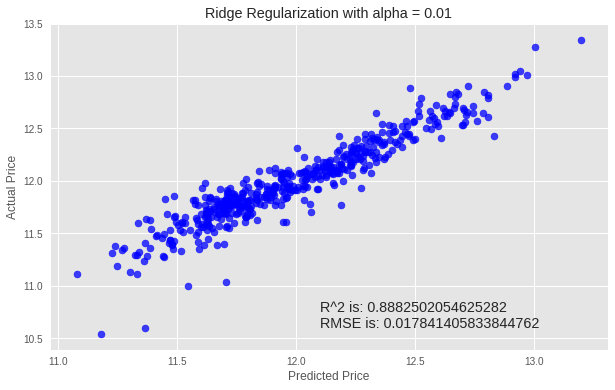

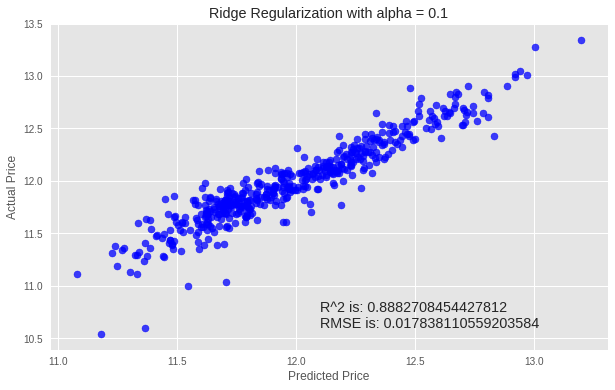

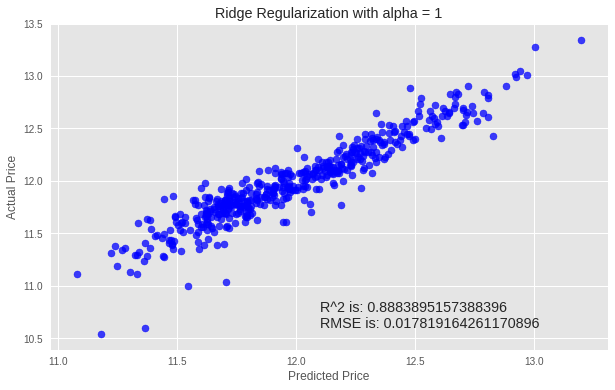

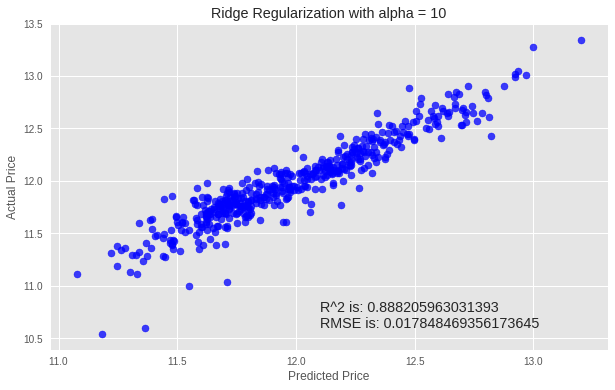

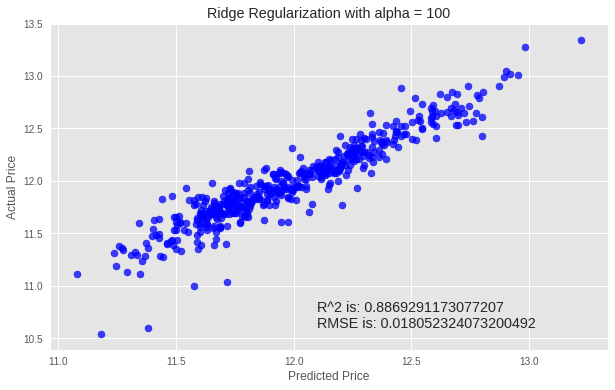

In [50]:
for i in range (-2, 3):
    alpha = 10**i
    rm = linear_model.Ridge(alpha=alpha)
    ridge_model = rm.fit(X_train, y_train)
    preds_ridge = ridge_model.predict(X_test)

    plt.scatter(preds_ridge, actual_values, alpha=.75, color='b')
    plt.xlabel('Predicted Price')
    plt.ylabel('Actual Price')
    plt.title('Ridge Regularization with alpha = {}'.format(alpha))
    overlay = 'R^2 is: {}\nRMSE is: {}'.format(
                    ridge_model.score(X_test, y_test),
                    mean_squared_error(y_test, preds_ridge))
    plt.annotate(s=overlay,xy=(12.1,10.6),size='x-large')
    plt.show()

As you add more features, regularization can be helpful. Repeat this step after you've added more features.

## Step 4: Make a submission

In [0]:
submission = pd.DataFrame()
submission['Id'] = test.Id

In [0]:
feats = test.select_dtypes(
        include=[np.number]).drop(['Id'], axis=1).interpolate()

In [0]:
predictions = model.predict(feats)

In [0]:
final_predictions = np.exp(predictions)

In [55]:
print ("Original predictions are: \n", predictions[:5], "\n")
print ("Final predictions are: \n", final_predictions[:5])

Original predictions are: 
 [11.76725362 11.71929504 12.07656074 12.20632678 12.11217655] 

Final predictions are: 
 [128959.49172586 122920.74024355 175704.82598101 200050.83263755
 182075.46986405]


In [56]:
submission['SalePrice'] = final_predictions
submission.head()

,Id,SalePrice
0,1461,128959.491726
1,1462,122920.740244
2,1463,175704.825981
3,1464,200050.832638
4,1465,182075.469864


In [0]:
submission.to_csv('submission1.csv', index=False)